In [1]:
from util import *
from SGPmodel import *
from api import *

In [45]:
class LatentSmileConverter(object):
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder

    def toSmile(self, *args):
        return self.decoder(*args)
    
    def toLatent(self, smiles):
        return self.encoder(smiles)


class ScoreCalculator(object):
    def __init__(self, scorecalc):
        self.scorecalc = scorecalc

    def __call__(self, smiles):
        score = []
        for s in smiles:
            score.append(self.scorecalc(s))
        return score
    

# Define BO function using general API:
# LSC for LatentSmileConverter object
def BayesianOpt_ei(LSC, SC, model, likelihood, max_iteration = 50, device = "cuda"):
    lb = torch.min(model.train_inputs[0], dim = 0)[0]
    ub = torch.max(model.train_inputs[0], dim = 0)[0]
    valid_s = []
    mol_score = []
    for iteration in range(max_iteration):
        if iteration == 0:
            flag = False
        else:
            flag = True
        xmin = next_x_ei(model, likelihood, model.train_inputs[0], lb,ub,flag,5,1, device)
        valid_smiles=[]
        scores=[]
        real_scores = []
        for x_new in xmin:
            # TODO
            tree_vec, mol_vec = x_new.chunk(2,1)
            s=LSC.toSmile(tree_vec, mol_vec)
            if s is not None:
                valid_smiles.append(s)
                score = SC(s)
                y_new = score
                #print("new x score:", score)
                scores.append(y_new)

                X = torch.cat((model.train_inputs[0], x_new.to("cuda")),0) # incorporate new evaluation
                y = torch.cat((model.train_targets, torch.tensor([y_new]).float().to("cuda")),0)

        if iteration < max_iteration-1:
            update_posterior(model, likelihood, X, y)
        print(len(scores)," new molecules are found. Iteration-",iteration)
        valid_s += valid_smiles
        mol_score += scores
        #save_object(valid_smiles, save_dir + "/valid_smiles{}.txt".format(iteration))
        #save_object(scores, save_dir + "/scores{}.txt".format(iteration))
    good_score = []
    good_s = []
    for i, s in enumerate(valid_s):
        if "CCCCCCCCC" not in s and "C(C)(C)C(C)(C)C(C)(C)" not in s:
            good_s.append(s)
            good_score.append(mol_score[i])
    return good_s, good_score

def BayesianOpt_ei_one_step(LSC, SC, model, likelihood, num_mol =1, max_iteration = 50, device = "cuda"):
    lb = torch.min(model.train_inputs[0], dim = 0)[0]
    ub = torch.max(model.train_inputs[0], dim = 0)[0]
    valid_s = []
    mol_score = []
    xmin = []
    for i in range(num_mol):
        flag = i
        xmin += next_x_ei(model, likelihood, model.train_inputs[0], lb,ub,flag,5,1, device)
    valid_smiles=[]
    for x_new in xmin:
        # TODO
        tree_vec, mol_vec = x_new.chunk(2,1)
        s=LSC.toSmile(tree_vec, mol_vec)
        if s is not None:
            valid_smiles.append(s)

    return valid_smiles, xmin

class SGPOptimizer(object):
    def __init__(self, X, y, device = "cuda"):
        self.X_train, self.y_train, self.X_test, self.y_test = generate_train_data(X, y, device)
        # TODO: how to determine number of inducing points
        self.SGP = Sparse_GP(self.X_train, self.y_train, device, 1000)
        self.device = device
        
    def train_SGP(self, train_iterations = 200):
        with gpytorch.settings.use_toeplitz(True):
            self.SGP.train(train_iterations)
            
    def optimize_smiles(self, smiles_w_scores, converter):
        pass
    
    def optimize_auto(self, X_y, LSC, SC):
        if X_y is not None:
            X, y = X_y
            X = torch.cat((self.SGP.model.train_inputs[0], X.to(self.device)),0) # incorporate new evaluation
            y = torch.cat((self.SGP.model.train_targets, y.float().to(self.device)),0)
        else:
            X, y = self.SGP.model.train_inputs[0], self.SGP.model.train_targets
        result = []
        self.SGP.model.set_train_data(X, y, strict = False)
        with gpytorch.settings.cg_tolerance(10), gpytorch.settings.max_cg_iterations(1500):
            valid_s, mol_score = BayesianOpt_ei(LSC, SC, self.SGP.model, self.SGP.likelihood, max_iteration=10)
            result.append((valid_s, mol_score))
        return result
    
    def optimize_one_step(self, X_y, LSC, num_mol = 1):
        if X_y is not None:
            X, y = X_y
            X = torch.cat((self.SGP.model.train_inputs[0], torch.cat(X).to(self.device)),0) # incorporate new evaluation
            y = torch.cat((self.SGP.model.train_targets, torch.Tensor(y).float().to(self.device)),0)
            update_posterior(self.SGP.model, self.SGP.likelihood, X, y)
        else:
            X, y = self.SGP.model.train_inputs[0], self.SGP.model.train_targets
        self.SGP.model.set_train_data(X, y, strict = False)
        with gpytorch.settings.cg_tolerance(10), gpytorch.settings.max_cg_iterations(1500):
            result, latent = BayesianOpt_ei_one_step(LSC, SC, self.SGP.model, self.SGP.likelihood, 10, max_iteration=1)
        return result, latent

    
    def save(self, trained_data=True):
        torch.save(self.SGP.model.state_dict(), 'SGPoptimizer.pth')
    
    def load(self, trained_data=True):
        state_dict = torch.load('SGPoptimizer.pth')
        self.SGP.model.load_state_dict(state_dict)
    

In [23]:
vocab_path = "/home/ubuntu/ASAIL/jtnn_bo/jtnn/JTNN_BO/jtnn/vocab.txt"
model_path = "/home/ubuntu/ASAIL/jtnn_bo/jtnn/JTNN_BO/jtnn/model.iter-0-3000"

JT_model = make_vae_model(vocab_path, model_path, device="cuda")
SC = ScoreCalculator(compute_mol_score)
LSC = LatentSmileConverter(JT_model.encode, JT_model.decode)


In [4]:
device = "cuda"
feature_dir = '/home/ubuntu/ASAIL/jtnn_bo/jtnn/bo/latent_features2.txt'
target_dir = '/home/ubuntu/ASAIL/jtnn_bo/jtnn/bo/targets2.txt'
training_num = 100000

X = np.loadtxt(feature_dir)[:training_num]
y = -np.loadtxt(target_dir)[:training_num]
y = y.reshape((-1, 1))

optimizer = SGPOptimizer(X, y)

Training data shape X:torch.Size([90000, 56]), y:torch.Size([90000])
Testing data shape X:torch.Size([10000, 56]), y:torch.Size([10000])


In [ ]:
optimizer.train_SGP(200)
optimizer.save()

In [34]:
optimizer = SGPOptimizer(X, y)
optimizer.load()
result, latent = optimizer.optimize_one_step(None, LSC)

Training data shape X:torch.Size([90000, 56]), y:torch.Size([90000])
Testing data shape X:torch.Size([10000, 56]), y:torch.Size([10000])
previous best: tensor([-4.1780], device='cuda:0')
min_score: -1.2505100965499878
previous best: tensor([-4.1780], device='cuda:0')
min_score: 0.04235526919364929
previous best: tensor([-4.1780], device='cuda:0')
min_score: 6.035830974578857
previous best: tensor([-4.1780], device='cuda:0')
min_score: -1.2213503122329712
previous best: tensor([-4.1780], device='cuda:0')
min_score: 6.035830974578857
previous best: tensor([-4.1780], device='cuda:0')
min_score: -1.1873714923858643
previous best: tensor([-4.1780], device='cuda:0')
min_score: 6.035830974578857
previous best: tensor([-4.1780], device='cuda:0')
min_score: 6.035830974578857
previous best: tensor([-4.1780], device='cuda:0')
min_score: 6.035830974578857
previous best: tensor([-4.1780], device='cuda:0')
min_score: 5.602463245391846


['CCC(CC)NC(=O)[C@@H](C)NC(=O)c1cccc(C(F)(F)F)c1', 'CCCCCCCCCCCCCCCCCCC', 'Cc1cc(C(=O)NCCCCCC=O)ccc1NC(=O)c1ccc(-c2ccc(C(C)C)cc2)cc1', 'CCCCCCCNC(=O)CCC[C@@H](C)C(C)C', 'C[C@@H](C(=O)Nc1cccc(C(=O)Nc2ccccc2C(F)(F)F)c1)c1ccccc1F', 'CCCCCCCCCCC(=O)NCCCCOCc1ccccc1', 'CCCC[C@@H](CC(=O)NCc1cccc(C(F)(F)F)c1)C(=O)[O-]', 'CCCCCNC(=O)C[C@H](CCCCC)C(=O)NCCC', 'CC(C)[C@@H](C(=O)Nc1ccccc1C(F)(F)F)N1CCOCC1', 'CC[C@@H](Cc1ccccc1C(F)(F)F)NC(=O)c1cccc(NC(=O)c2ccccc2C)c1']
Start drawing 10 mols:


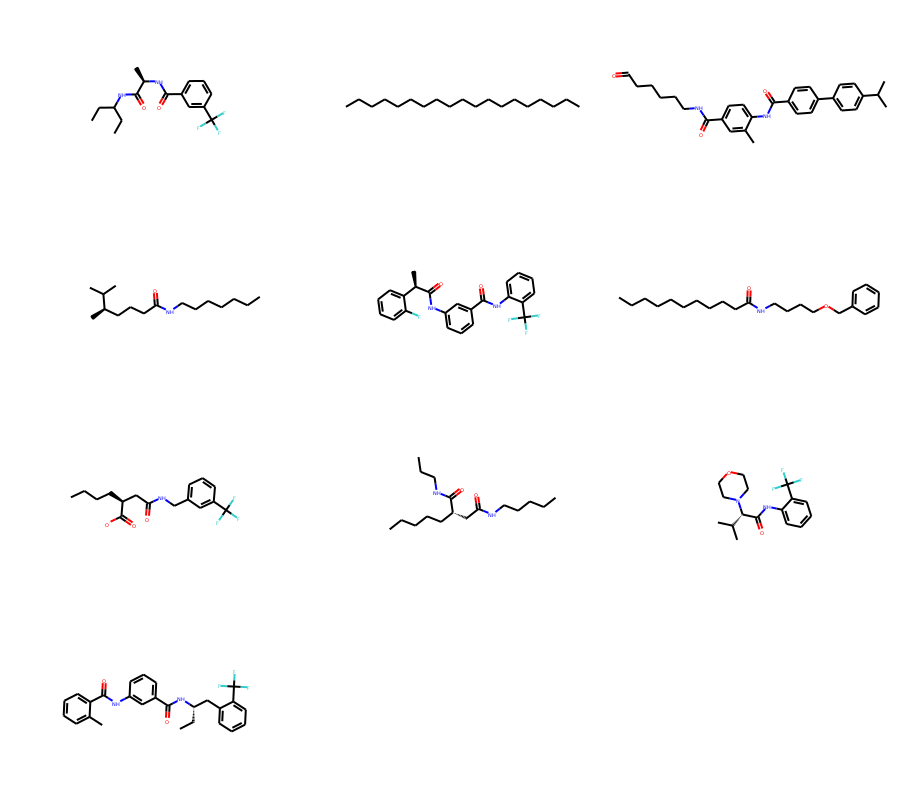

In [50]:
print(result)
img = draw_mol(result)
img

In [51]:
score = SC(result)
print(score)

[1.3230777713528665, 6.174741840546357, 4.096888401956597, 2.397405540251337, 3.154091260398101, 3.8364451155048283, 0.20473772676558685, 1.5114494864558703, 1.0236119991995283, 3.2104058368525097]


In [49]:
optimizer = SGPOptimizer(X, y)
optimizer.load()
result, latent = optimizer.optimize_one_step([latent, score], LSC)

Training data shape X:torch.Size([90000, 56]), y:torch.Size([90000])
Testing data shape X:torch.Size([10000, 56]), y:torch.Size([10000])
train with X.shape - torch.Size([90010, 56]), y.shape - torch.Size([90010])
Iter 10/50 - Loss: 1.524  noise: 0.196
Iter 20/50 - Loss: 1.619  noise: 0.204
Iter 30/50 - Loss: 1.588  noise: 0.215
Iter 40/50 - Loss: 1.609  noise: 0.218
Iter 50/50 - Loss: 1.597  noise: 0.215
previous best: tensor([-3.9723], device='cuda:0')
min_score: -1.270574927330017
previous best: tensor([-3.9723], device='cuda:0')
min_score: 6.170449256896973
previous best: tensor([-3.9723], device='cuda:0')
min_score: 6.170449256896973
previous best: tensor([-3.9723], device='cuda:0')
min_score: 6.170449256896973
previous best: tensor([-3.9723], device='cuda:0')
min_score: -1.4192578792572021
previous best: tensor([-3.9723], device='cuda:0')
min_score: 6.170449256896973
previous best: tensor([-3.9723], device='cuda:0')
min_score: -1.4076409339904785
previous best: tensor([-3.9723], d

In [ ]:
smiles = ["cCCC"]
X_train = np.load(...)
y_train = np.load(...)
optimizer = SGPOptimizer(X_train, y_train)
optimizer.load(...)
new_smiles = optimizer.optimize_smiles([smiles, scores], LatentSmileConverter(JT_model))
# Or

X = np.load(...)
y = np.load(...)
new_smiles = optimizer.optimize_vec([X, y], LatentSmileConverter(model))
optimizer.save(...)